In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from Constants import *
from pyOrbits import Orbit
from GCB import GCBWaveform
from pyWaveForm import BasicWaveform
from pyTDResponse import TDResponse
from pyINIDetectors import INITianQin, INILISA

from Constants import *
from utils import dot_arr, cal_zeta, sYlm
from pyOrbits import Orbit
from pyWaveForm import *

from pyFDResponse import FDResponse
from TDI import XYZ_FD, AET_FD

This is a test for frequency domain response
Testing of BHB waveform
time cost for the fd response is 0.01030588150024414 s


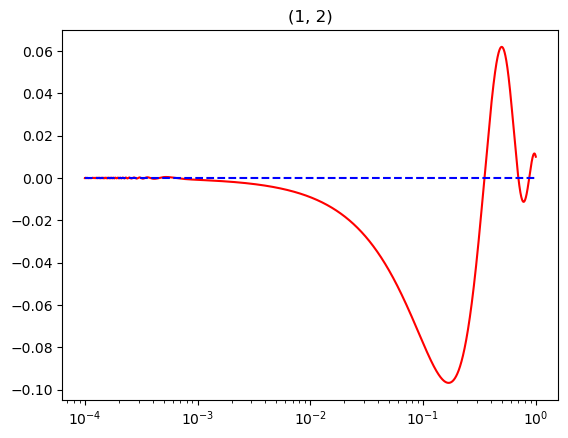

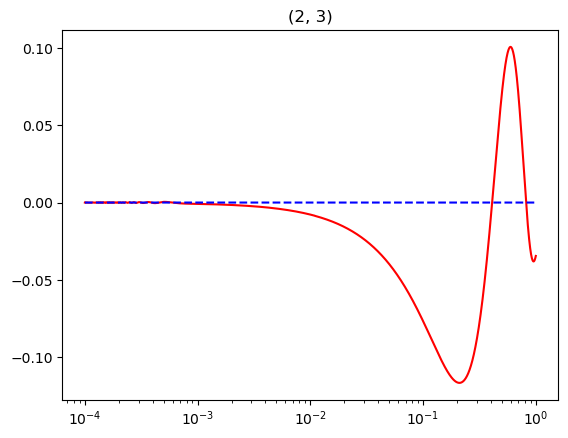

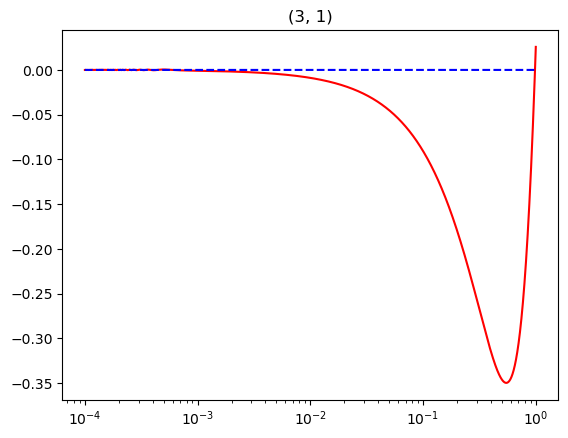

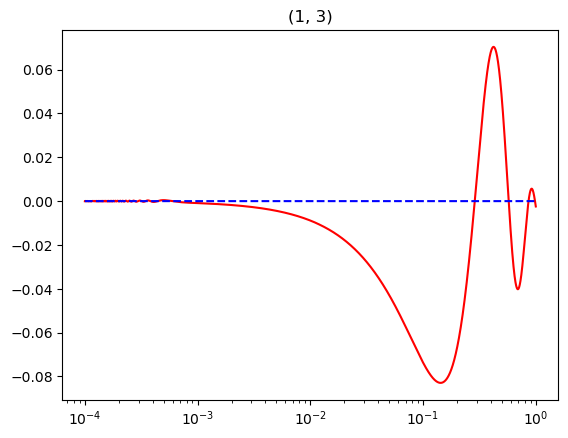

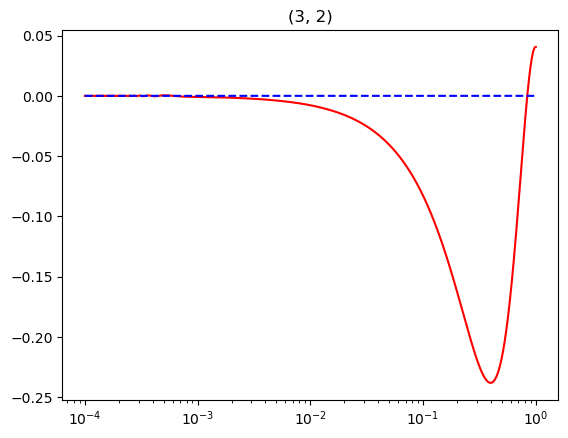

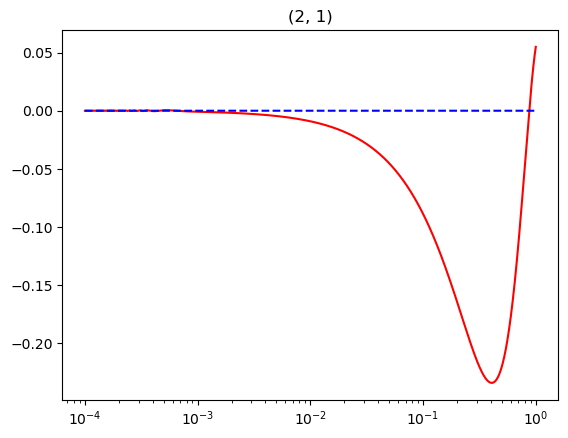

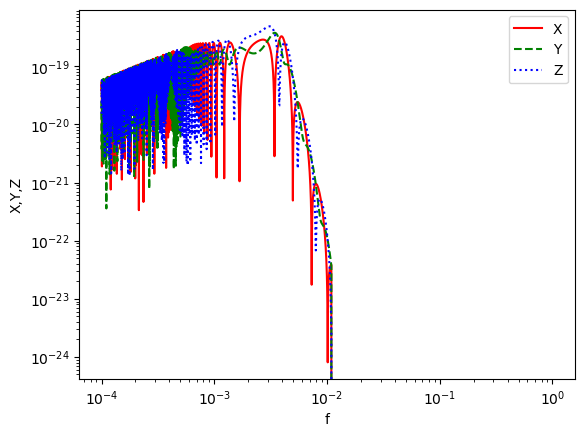

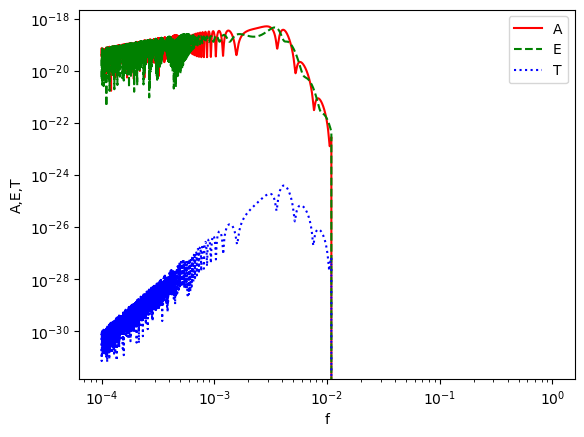

<Figure size 640x480 with 0 Axes>

In [4]:
%run pyFDResponse.py

Here is the analytical orbits
Time cost for initial position: 0.024137 s
Time cost for generate orbit pos is 0.581264 s for 2629846 point
Time cost for generat vel if 0.578892 s for 2629846 point
Time cost for generat vel if 0.085711 s for 2629846 point


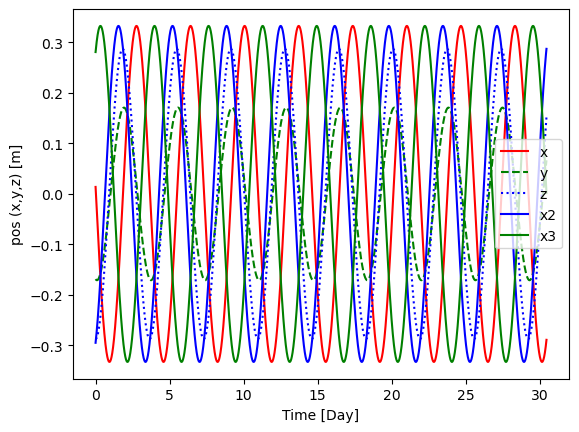

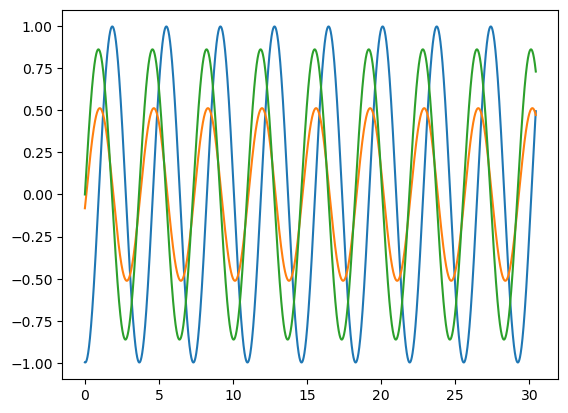

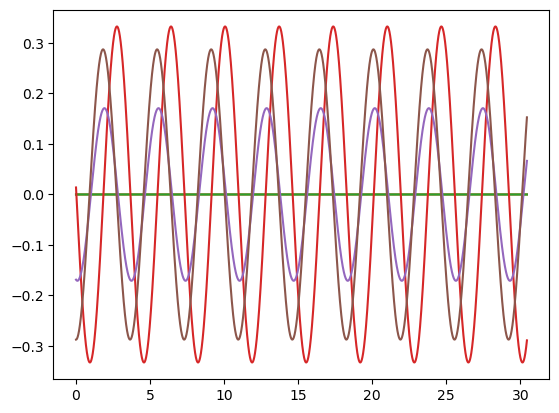

<Figure size 640x480 with 0 Axes>

In [5]:
%run pyOrbits.py

This is the BHB waveform
2592000
Time cost is 1.1798784732818604 s


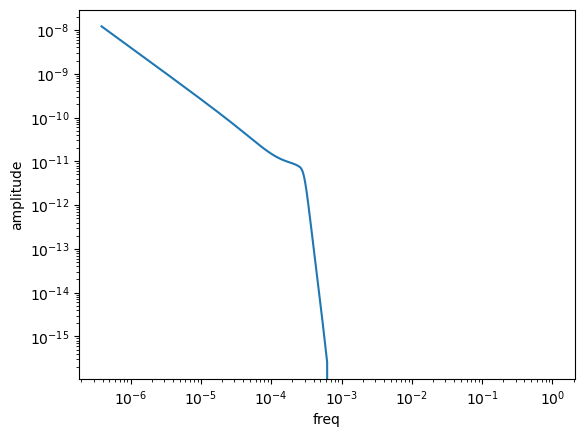

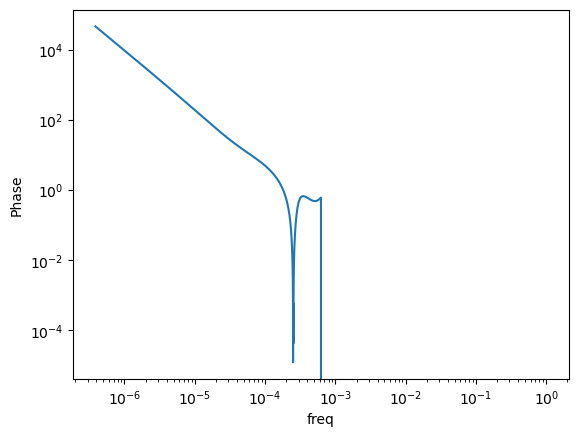

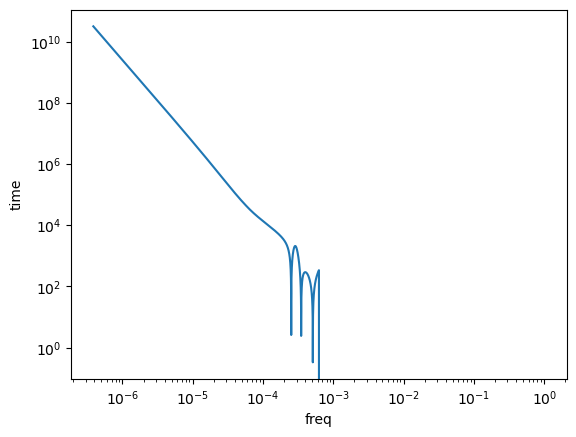

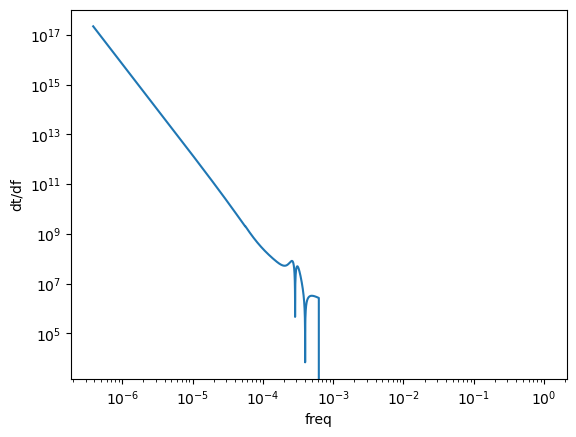

<Figure size 640x480 with 0 Axes>

In [6]:
%run BHB.py

In [12]:
Tobs = 4* DAY
T = Tobs/YRSID_SI
dt = 1
tf = np.arange(0,Tobs,dt)

In [20]:
tf

array([     0,      1,      2, ..., 345597, 345598, 345599])

In [21]:
np.linspace(0, Tobs, int(Tobs/dt))

array([0.00000000e+00, 1.00000289e+00, 2.00000579e+00, ...,
       3.45598000e+05, 3.45599000e+05, 3.45600000e+05])

In [22]:
tf.shape, tf[-1], T*YRSID_SI, Tobs, int(Tobs/dt)

((345600,), 345599, 345600.0, 345600, 345600)